# Misdirection

Some experiments into how gpt2-small behaves when generating false output.

Semantic structure misdirects the model to produce incorrect output. For example,

> They realise John was two years older than Mary. Mary was born before ..."

In [1]:
import torch
from transformer_lens import HookedTransformer 
import plotly.io as pio
import matplotlib.pyplot as plt

from utils import *

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
from itertools import permutations, product

def generate_prompts(templates, names):
    return [
        (prompt.format(S, IO), (IO, S))
        for prompt, (S, IO) in product(templates, permutations(names, 2))
    ]

Create clean and corrupted prompt datasets where the corrupted prompts contradict the initial context. Each set is run against the model so we have access to clean and corrupted cached activations.

In [3]:
names = (" Mary", " John", " Alice", " Bob")
prompts = generate_prompts(
    [
        "{0} was two years older than{1}. Who was born first?{0} was born before",
        "{0} was two years younger than{1}. Who was born last?{0} was born after",
    ],
    names
)

corrupted_prompts = generate_prompts(
    [
        "{0} was two years older than{1}. Who was born first?{1} was born before",
        "{0} was two years younger than{1}. Who was born last?{1} was born after",
    ],
    names
)

promtps_equal_length = all([
    len(model.to_str_tokens(p)) for p, _ in prompts + corrupted_prompts
])

if not promtps_equal_length:
    print("Prompts are not equal length")
len(prompts), len(corrupted_prompts), prompts[0], corrupted_prompts[0]

(24,
 24,
 (' Mary was two years older than John. Who was born first? Mary was born before',
  (' John', ' Mary')),
 (' Mary was two years older than John. Who was born first? John was born before',
  (' John', ' Mary')))

In [4]:
model.remove_all_hook_fns()
cache = run_prompts(model, *[p for p, _ in prompts])
corrupted_cache = run_prompts(model, *[p for p, _ in corrupted_prompts])

Below prints the tokens against the logit value for each. The generated output is added to the end.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


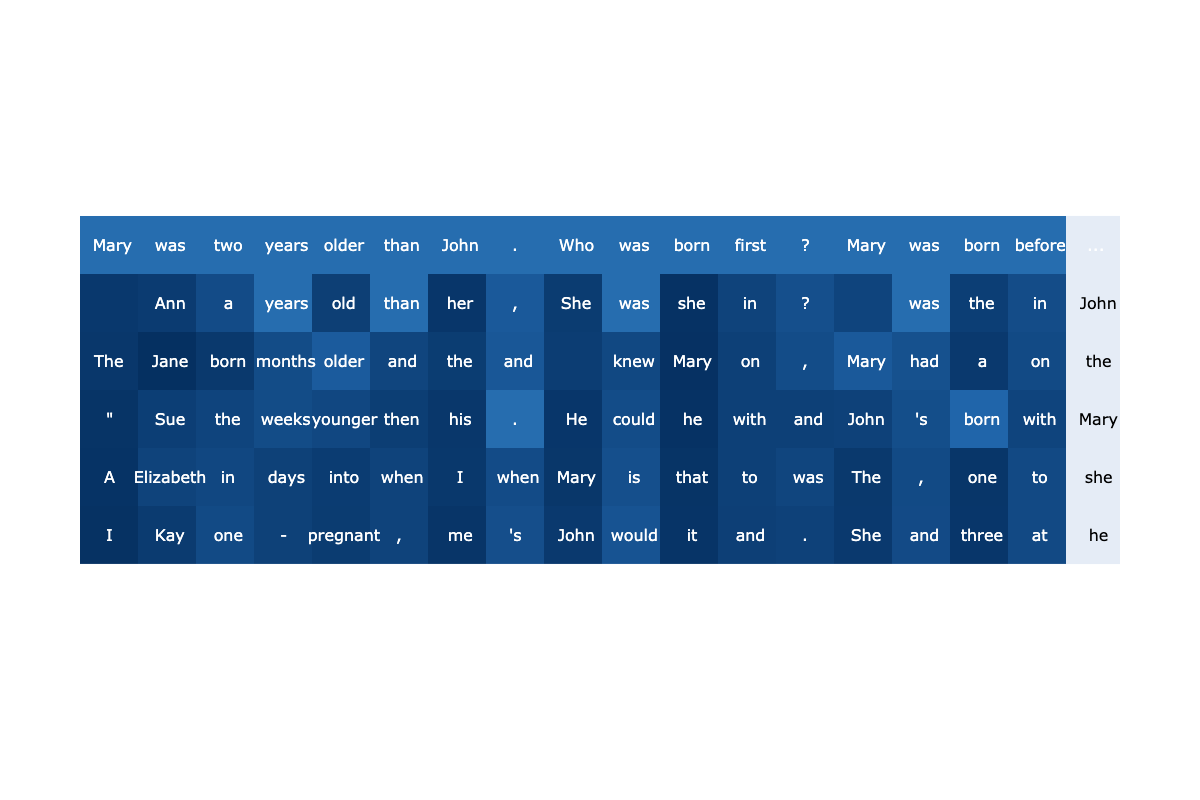

In [5]:
print_max_logits(cache, k=5)

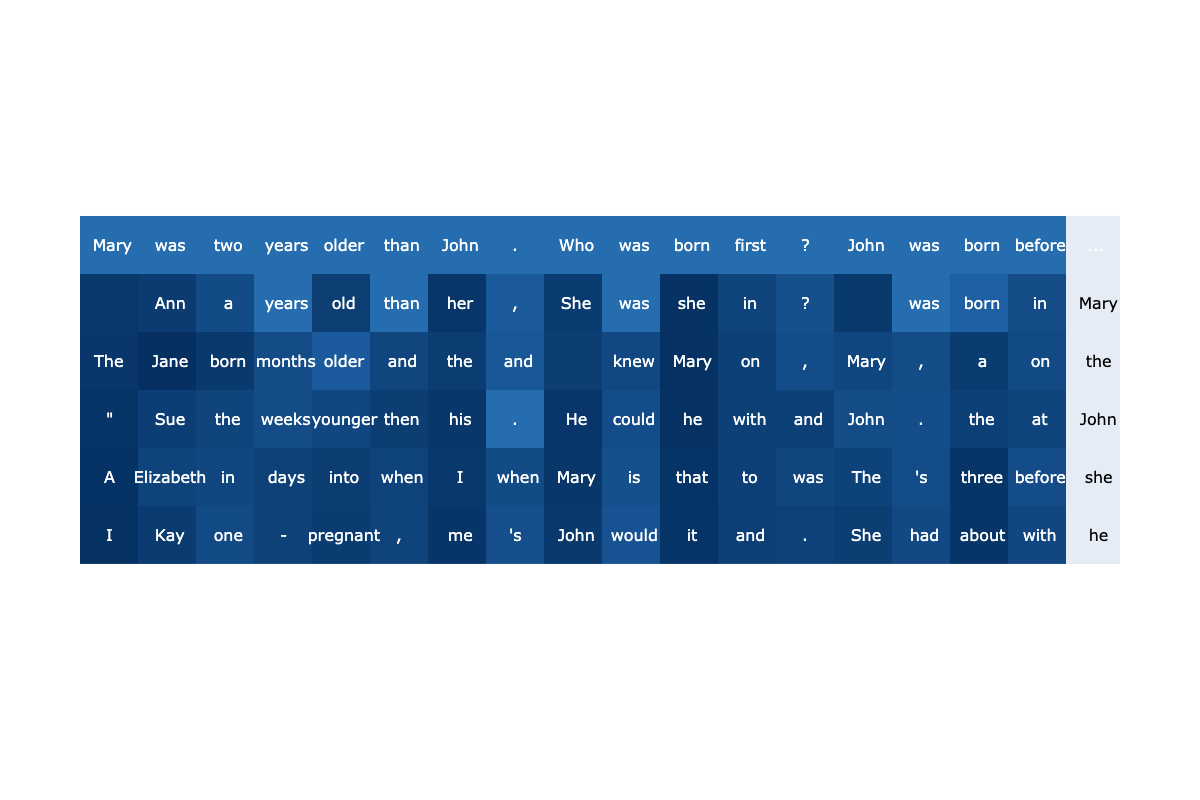

In [6]:
print_max_logits(corrupted_cache, k=5)

Interestingly, in the corrupted prompt, we see a slightly increased confidence of the false output (~10% increase).

Looking at the attention head patterns many of the top positive and negative contributors are shared, but there are a few noteable exceptions.

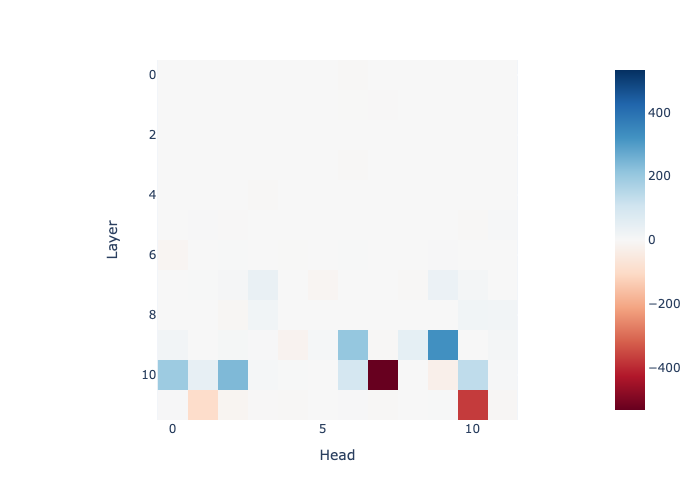

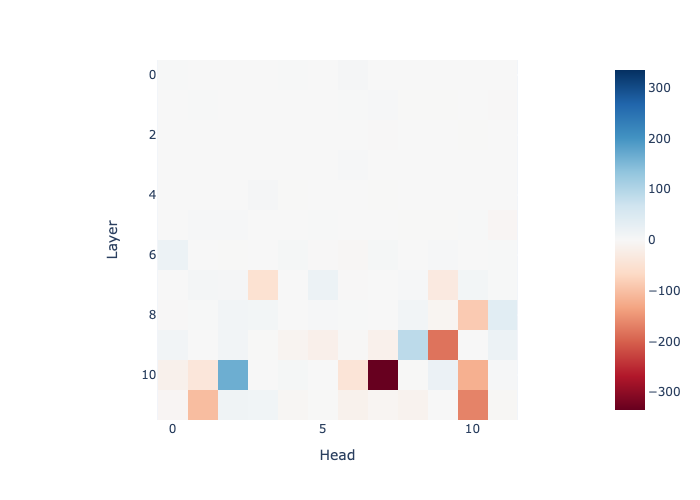

(None, None)

In [9]:
a = px.imshow(
    calculate_head_contribution(cache, calculate_logit_diff(cache, [cs for _, cs in prompts])).cpu(),
    labels={"x": "Head", "y": "Layer"},
    color_continuous_midpoint=0.0,
    color_continuous_scale="rdbu",
)

b = px.imshow(
    calculate_head_contribution(corrupted_cache, calculate_logit_diff(corrupted_cache, [cs for _, cs in corrupted_prompts])).cpu(),
    labels={"x": "Head", "y": "Layer"},
    color_continuous_midpoint=0.0,
    color_continuous_scale="rdbu",
)

a.show(), b.show()

A couple of the top positive heads (e.g. 10.2, 9.8) are shared, but otherwise the top positive contributors for the clean inputs are the top negative contributors for the corrupted inputs (e.g. 9.9, 10.0, 10.6, etc). Many of these are name-mover heads from the IOI paper.

### Postive head patterns

We can dig into this further by looking at what those attention patterns attend to for each input.

In [10]:
labels, patterns = [], []
for head in range(144):
    layer = head // cache.model.cfg.n_heads
    head_index = head % cache.model.cfg.n_heads
    labels.append(f"L{layer}H{head_index}")
    patterns.append(cache["attn", layer][0, head_index])

patterns = torch.stack(patterns, dim=0)

In [ ]:
k = 5
logit_diff = calculate_logit_diff(cache)
per_head_logit_diffs = calculate_head_contribution(cache, logit_diff)
heads = torch.topk(per_head_logit_diffs.flatten(), k=k).indices

corrupted_logit_diff = calculate_logit_diff(corrupted_cache)
corrupted_per_head_logit_diffs = calculate_head_contribution(corrupted_cache, corrupted_logit_diff)
corrupted_heads = torch.topk(corrupted_per_head_logit_diffs.flatten(), k=k).indices

patterns = calculate_attention_patterns(cache, heads)
corrupted_patterns = calculate_attention_patterns(corrupted_cache, corrupted_heads)

figs = plot_attention_patterns(patterns)
corrupted_figs = plot_attention_patterns(corrupted_patterns)

display(plot_grid(figs, title=f'Top {k} attention heads for clean prompts'))
plot_grid(corrupted_figs, title=f'Top {k} attention heads for corrupted prompts')

In [ ]:
neg_heads = torch.topk(-per_head_logit_diffs.flatten(), k=k).indices
neg_corrupted_heads = torch.topk(-corrupted_per_head_logit_diffs.flatten(), k=k).indices

neg_patterns = calculate_attention_patterns(cache, neg_heads)
neg_corrupted_patterns = calculate_attention_patterns(corrupted_cache, neg_corrupted_heads)

neg_figs = plot_attention_patterns(neg_patterns)
neg_corrupted_figs = plot_attention_patterns(neg_corrupted_patterns)

display(plot_grid(neg_figs, title=f'Bottom {k} attention heads for clean prompts'))
plot_grid(neg_corrupted_figs, title=f'Bottom {k} attention heads for corrupted prompts')

### All heads

I find it interesting to plot the full set of heads by layer to get a sense of how they react under different inputs. Sometimes it's easier to see that there is some kind of pattern or common elements and work backwards - instead of only looking at heads that are deemed "important" using some metric like logit difference. See the pathological inputs notebook for more on this.

In [ ]:
heads = calculate_attention_patterns(cache, range(144))
corrupted_heads = caheads = calculate_attention_patterns(corrupted_cache, range(144))

display(
    plot_grid(
        plot_attention_patterns(heads),
        rows=12,
    )
)

display(
    plot_grid(
        plot_attention_patterns(corrupted_heads),
        rows=12,
    )
)

## Activation patching

We can use activation patching to replace the output of specific components to understand how they contribute to the overall generation process. 

For example, let's try patching these heads, which demonstrate some interesting differences between the clean and corrupted inputs. 

In [ ]:
_, cache = model.run_with_cache([p[0] for p in prompts])
cache.prompts = prompts
_, corrupted_cache = model.run_with_cache([p[0] for p in corrupted_prompts])
corrupted_cache.prompts = corrupted_prompts

indices = [
    (5, 5),
    (6, 9),
]

indices = [ i * cache.model.cfg.n_heads + j for i, j in indices ]
heads = calculate_attention_patterns(cache, indices, component='attn')
corrupted_heads = caheads = calculate_attention_patterns(corrupted_cache, indices, component='attn')

display(
    plot_grid(
        plot_attention_patterns({
            **{f'{k} (clean)': v for k, v in heads.items()},
            **{f'{k} (corrupted)': v for k, v in corrupted_heads.items()}
        }),
    )
)

In the clean input the heads attend to specific tokens in the first sentence which correspond to the question being asked in the current sentence. In the corrupted inputs, where the model is misdirected to produce a false answer, the heads instead attend to the fullstop marking the end of the first sentence.

Swapping the Q activations at these heads between the clean and corrupted caches produces surprising attention patterns. 5.5 is reconstructed almost precisely in both directions, but 6.9 transforms to a very different pattern. However, that pattern is precisely the same in both cases.

In [ ]:
model.remove_all_hook_fns()
activation = 'attn.hook_q'

def swap_attention(index):
    def hook_fn(t, hook):
        t[:, :, index] = corrupted_cache[f'blocks.{index}.{activation}'][:, :, index]
    return hook_fn

model.add_hook(f'blocks.5.{activation}', swap_attention(5))
model.add_hook(f'blocks.6.{activation}', swap_attention(9))

_, ablated_cache = model.run_with_cache([p[0] for p in prompts])
ablated_cache.prompts = prompts

ablated_heads = calculate_attention_patterns(ablated_cache, indices, component='attn')

display(
    plot_grid(
        plot_attention_patterns({
            **{f'{k} (clean)': v for k, v in heads.items()},
            **{f'{k} (clean ablated)': v for k, v in ablated_heads.items()},
        }),
    )
)

In [ ]:
model.remove_all_hook_fns()
activation = 'attn.hook_q'

def swap_attention(index):
    def hook_fn(t, hook):
        t[:, :, index] = cache[f'blocks.{index}.{activation}'][:, :, index]
    return hook_fn

model.add_hook(f'blocks.5.{activation}', swap_attention(5))
model.add_hook(f'blocks.6.{activation}', swap_attention(9))

_, ablated_cache = model.run_with_cache([p[0] for p in corrupted_prompts])
ablated_cache.prompts = corrupted_prompts

ablated_heads = calculate_attention_patterns(ablated_cache, indices, component='attn')

display(
    plot_grid(
        plot_attention_patterns({
            **{f'{k} (corrupted)': v for k, v in corrupted_heads.items()},
            **{f'{k} (corrupted ablated)': v for k, v in ablated_heads.items()},
        }),
    )
)

In [ ]:
model.remove_all_hook_fns()
_, cache = model.run_with_cache([p[0] for p in prompts], return_cache_object=True)
cache.prompts = prompts

In [ ]:
prompts

In [ ]:
l = -1
h = -2
q = cache['q', l].reshape(-1, 18, 12 * 64)
q.shape

In [ ]:
cache['k', l].shape

In [ ]:
k = cache['k', l].reshape(-1, 18, 12 * 64)
k.shape

In [ ]:
attention_scores = torch.bmm(q, k.transpose(1, 2))
attention_scores.shape

In [ ]:
scaling_factor = torch.sqrt(torch.tensor(768, dtype=torch.float32))
scaled_attention_scores = attention_scores / scaling_factor
scaled_attention_scores.shape

In [ ]:
z = q + k
z.shape

In [ ]:
lnt = cache.model.OV[l, h, :, :]
lnt.A.shape, lnt.B.shape

In [ ]:
q_proj= torch.einsum('bik,kj->bij', q, lnt.A)
q_proj.shape

In [ ]:
q_proj_b = torch.einsum('bik,kl->bil', q_proj, lnt.B)
q_proj_b.shape

In [ ]:
logits = cache.model.unembed(q_proj_b)
logits.shape

In [ ]:
pred_tokens = logits.argmax(dim=-1)
pred_tokens.shape

In [ ]:
mlp_in = model.W_in[l]
mlp_out = model.W_out[l]

mlp_in.shape, mlp_out.shape

In [ ]:
rm = cache[('resid_post', l)]
rm.shape

In [ ]:
v = cache['v', l].reshape(-1, 18, 12 * 64)
v.shape

In [ ]:
from transformer_lens.utils import Slice
pos_slice = Slice((0, 4))
vv = pos_slice.apply(v, dim=-2)
vv.shape

In [ ]:
pos_slice = slice(0, 11)
v = v[:, pos_slice, :]
v.shape

In [ ]:
v = vv
v_proj = torch.einsum('bik,kj->bij', v, lnt.A)
v_proj = torch.einsum('bik,kl->bil', v_proj, lnt.B)
v_proj.shape

In [ ]:
v_mlped = torch.einsum('bik,kj->bij', v_proj, mlp_in)
v_mlped_out = torch.einsum('bik,kl->bil', v_mlped, mlp_out)

v_mlped.shape, v_mlped_out.shape

In [ ]:
v_logits = cache.model.unembed(v_mlped_out)
v_logits.shape

In [ ]:
v_preds = v_logits.argmax(dim=-1)
v_str_preds = cache.model.to_str_tokens(v_preds[0])
v_str_preds

In [ ]:
pred_str_tokens = cache.model.to_str_tokens(pred_tokens[0])
print(pred_str_tokens)

In [ ]:
_prompts = [p[:100] for p, _ in prompts]
_, short_cache = model.run_with_cache(_prompts, return_cache_object=True)
corrupted_cache.prompts = _prompts

In [ ]:
interesting = [
    (6, 5),
    (8, 3),
    (10, 8),
    (11, 8),
]

In [ ]:
import random

cmap = 'haline'
plot_attention_pattern(
    cache,
    random.randint(0, 11),
    random.randint(0, 11),
    cmap=None,
    example_index=random.randint(0, 24),
)

In [ ]:
_prompts = [p for p, _ in prompts]
_prompts = [model.to_str_tokens(p) for p in _prompts]
_prompts = [p[:14] for p in _prompts]
_prompts = [''.join(p) for p in _prompts]
_prompts = [(p, ()) for p in _prompts]

_, short_cache = model.run_with_cache([p for p, _ in _prompts])
short_cache.prompts = _prompts

_prompts[:5]

In [ ]:
plot_attention_pattern(cache, 0, 1, cmap=None, example_index=0)

In [ ]:
plot_attention_pattern(cache, 8, 3, cmap=None, example_index=5)

In [ ]:
plot_attention_pattern(cache, 8, 3, cmap=None, example_index=10)

In [ ]:
plot_attention_pattern(short_cache, 8, 3, cmap=None, example_index=1)

In [ ]:
plot_attention_pattern(cache, 5, 5, cmap=cmap)

In [ ]:
plot_attention_pattern(cache, 6, 9, cmap=cmap)